In [1]:
!echo $PYTHONPATH
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

/home/dianloo/Desktop/tesi/quilt


In [2]:
from quilt.builder import NeuronCatalogue, SpikingNetwork

catalogue = NeuronCatalogue.from_yaml("tests/basal_ganglia_neurons.yaml")

Loaded model for neuron 'D1_neuron'

Loaded model for neuron 'D2_neuron'

Loaded model for neuron 'FSN_neuron'

Loaded model for neuron 'GPTi_neuron'

Loaded model for neuron 'GPTA_neuron'

Loaded model for neuron 'GPTI_neuron'

Loaded model for neuron 'STN_neuron'

Loaded model for neuron 'SNR_neuron'

In [3]:
sn = SpikingNetwork.from_yaml("tests/basal_ganglia_network.yaml", catalogue)

Output()

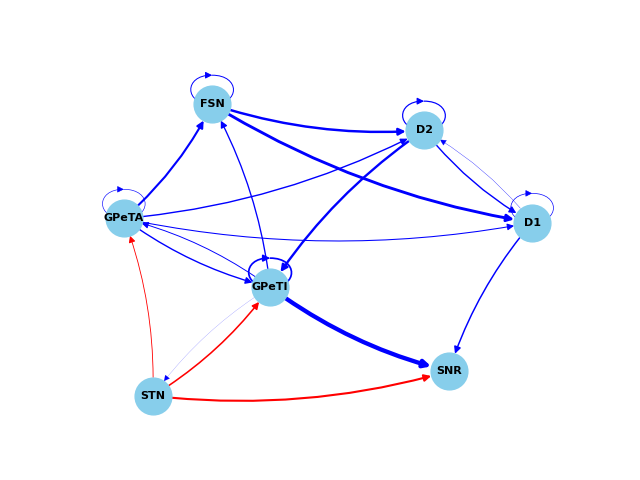

In [4]:
from quilt.view import plot_graph
fig, ax = plt.subplots()
plot_graph(sn)

In [5]:
pop_state_monitorized = "GPeTI"
for population in sn.populations.values():
    population.monitorize_spikes()
sn.populations[pop_state_monitorized].monitorize_states()

In [6]:
for pop in sn.populations.values():
    pop.add_injector(50, 0, 500)

sn.populations["D1"].add_injector(500,  # pA
                                  0,   # ms
                                  500   # ms
                                 )
sn.populations["D2"].add_injector(500,  # pA
                                  0,   # ms
                                  500   # ms
                                 )

In [7]:
sn.run(dt=0.1, time=800)

Running network consisting of 14622 neurons for 8000 timesteps

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Simulation took 91 s	(11.4956 ms/step)
	Gathering time avg: 236.748 us/step
	Inject time avg: 0.054875 us/step


In [8]:
spikes = dict()
for pop in sn.populations.keys():
    spikes[pop] = sn.populations[pop].get_data()['spikes']

states = sn.populations[pop_state_monitorized].get_data()['states']

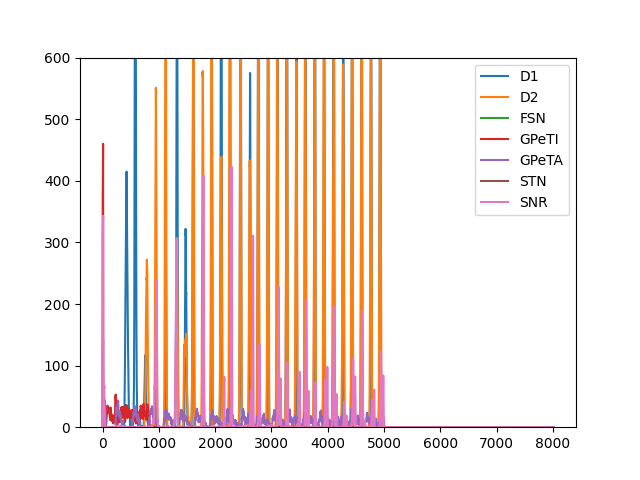

In [9]:
fig, ax = plt.subplots()
for pop in spikes.keys():
    N = 10
    
    plt.plot(np.convolve(spikes[pop], np.ones(N)), label=pop)
plt.ylim(0,600)
plt.legend()